In [8]:
import pandas as pd
import requests as r
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from app import app
from utils.settings import DETERMINISTIC_MODELS, DETERMINISTIC_VARS, ENSEMBLE_VARS, ENSEMBLE_MODELS, DEFAULT_TEMPLATE
import plotly.io as pio
import plotly.express as px
import plotly.figure_factory as ff
from utils.openmeteo_api import *
from pages.model_climate_daily.figures import make_prec_figure

In [2]:
sun = get_forecast_daily_data(variables='sunrise,sunset',
                              forecast_days=14)

In [9]:
data = get_forecast_data(model='icon_seamless,gfs_seamless',
                        forecast_days=14)

In [34]:
daily = get_historical_daily_data(
    model='era5_seamless',
    start_date='1981-01-01',
    end_date=(pd.to_datetime('now', utc=True) -
                pd.to_timedelta('1 day')).strftime("%Y-%m-%d"),
    variables='sunshine_duration')

data = get_forecast_daily_data(variables='sunshine_duration', past_days=5, forecast_days=1)
data['doy'] = data.time.dt.day_of_year
data['sunshine_duration'] = data['sunshine_duration'] / 3600.

<Axes: xlabel='doy'>

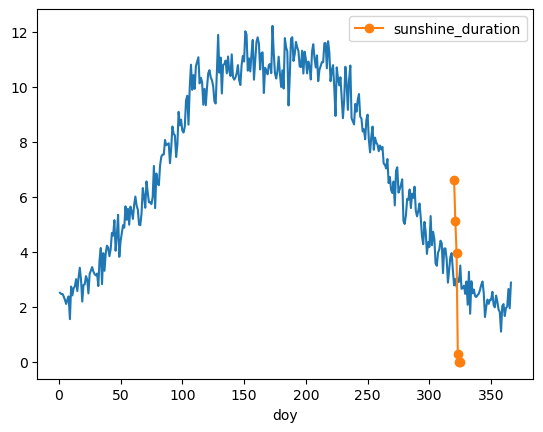

In [37]:
ax = (daily.groupby(daily.time.dt.dayofyear).mean().sunshine_duration/3600).plot()
data.plot(x='doy', y='sunshine_duration', ax=ax, style='o-')

In [4]:
data = compute_yearly_accumulation(model='era5_seamless',
                                   var='sunshine_duration')

In [6]:
for c in ['sunshine_duration', 'sunshine_duration_yearly_acc', 'q1', 'q2','q3']:
    data[c] = data[c] / 3600.

In [77]:
def make_lineplot_timeseries(df, var, mode='lines+markers', showlegend=False):
    traces = []
    # Define cyclical colors to be used
    colors = pio.templates[DEFAULT_TEMPLATE]['layout']['colorway'] * 5
    for i, col in enumerate(df.columns[df.columns.str.contains(var)]):
        traces.append(
            go.Scatter(
                x=df.loc[:, 'time'],
                y=df.loc[:, col],
                mode=mode,
                name=col.replace(var+"_",''),
                marker=dict(size=5, color=colors[i]),
                line=dict(width=2, color=colors[i]),
                showlegend=showlegend),
        )

    return traces


def make_windarrow_timeseries(df, var_speed='windgusts_10m', var_dir='winddirection_10m', showlegend=False):
    df = df[::6].copy()
    traces = []
    # Define cyclical colors to be used
    colors = pio.templates[DEFAULT_TEMPLATE]['layout']['colorway'] * 5
    
    i = 0
    for col_speed, col_dir in zip(df.columns[df.columns.str.contains(var_speed)], df.columns[df.columns.str.contains(var_dir)]):
        traces.append(
            go.Scatter(
                x=df.loc[:, 'time'],
                y=df.loc[:, col_speed],
                mode='markers',
                name='',
                marker=dict(size=10, color=colors[i],
                            symbol='arrow',
                            angle=df.loc[:, col_dir],
                            line=dict(width=1, color="DarkSlateGrey"),
                            ),
                showlegend=showlegend),
        )
        i += 1

    return traces


def make_barplot_timeseries(df, var):
    traces = []
    # Define cyclical colors to be used
    colors = pio.templates[DEFAULT_TEMPLATE]['layout']['colorway'] * 5
    for i, col in enumerate(df.columns[df.columns.str.contains(var)]):
        traces.append(
            go.Bar(
                x=df['time'],
                y=df[col],
                name=col.replace(var+"_",''),
                opacity=0.6,
                marker=dict(color='rgb(26, 118, 255)'),
                showlegend=False),
        )
        traces.append(
            go.Scatter(
                x=df.loc[df[col] >= 0.1, 'time'],
                y=df.loc[df[col] >= 0.1, col],
                mode='markers',
                name=col.replace(var+"_",''),
                marker=dict(size=3, color=colors[i]),
                showlegend=False),
        )
    

    return traces

def make_subplot_figure(data, title=None, sun=None):
    traces_temp = make_lineplot_timeseries(data, 'temperature_2m', showlegend=True)
    traces_precipitation = make_barplot_timeseries(data, 'precipitation')
    traces_wind = make_lineplot_timeseries(data, 'windgusts_10m', mode='lines')
    traces_wind_dir = make_windarrow_timeseries(data)
    traces_cloud = make_lineplot_timeseries(data, 'cloudcover', mode='markers')

    fig = make_subplots(
        rows=4,
        cols=1,
        shared_xaxes=True,
        vertical_spacing=0.03,
        row_heights=[0.5, 0.3, 0.3, 0.3])

    for trace_temp in traces_temp:
        fig.add_trace(trace_temp, row=1, col=1)
    for trace_precipitation in traces_precipitation:
        fig.add_trace(trace_precipitation, row=2, col=1)
    for trace_wind in traces_wind:
        fig.add_trace(trace_wind, row=3, col=1)
    for trace_wind_dir in traces_wind_dir:
        fig.add_trace(trace_wind_dir, row=3, col=1)
    for trace_cloud in traces_cloud:
        fig.add_trace(trace_cloud, row=4, col=1)

    fig.update_layout(
        xaxis=dict(showgrid=True,
                   range=[data['time'].min(),
                          data['time'].max()]),
        yaxis=dict(showgrid=True,),
        height=1000,
        margin={"r": 5, "t": 40, "l": 0.1, "b": 0.1},
        barmode='overlay',
        legend=dict(orientation='h',y=-0.04),
    )

    if sun is not None:
        for i, s in sun.iterrows():
            fig.add_vrect(
                x0=s['sunrise'],
                x1=s['sunset'],
                fillcolor="rgba(255, 255, 0, 0.3)",
                layer="below",
                line=dict(width=0),
                row=1, col=1
            )

    fig.update_yaxes(title_text="2m Temp [°C]", row=1, col=1)
    fig.update_yaxes(title_text="Prec. [mm]", row=2, col=1)
    fig.update_yaxes(title_text="Wind Gusts [kph]", row=3, col=1)
    fig.update_yaxes(title_text="Cloud cover [%]", row=4, col=1)
    fig.update_yaxes(showgrid=True, gridwidth=4)
    fig.update_xaxes(minor=dict(ticks="inside", showgrid=True,
                     gridwidth=1),
                     tickformat='%a %d %b\n%H:%M', showgrid=True, gridwidth=4)
    if title is not None:
        fig.update_layout(title_text=title)

    return fig

In [ ]:
make_subplot_figure(data, sun=sun)